# Training a model on CarbonTracker's carbon flux
This notebook outlines the entire workflow to load and preprocess the ERA5 and CarbonTracker data, to be able to train a ML model.

First download the CarbonTracker and monthly ERA5 data using the instructions in the README file.

The functions written to process the data are contained in `src/carbontracker.py`. We can import them with:

In [1]:
from src import carbontracker, biomass
import xarray as xr
import xarray_regrid

We will load the CarbonTracker data into an xarray `Dataset` and convert the timestamps (middle point of each month) to a more standard format (1st day of the month), to allow merging with ERA5 data.

In [2]:
ds_cb = xr.open_dataset("/home/bart/Data/EXCITED/CT2022.flux1x1-monthly.nc")
ds_cb = carbontracker.convert_ct_timestamps(ds_cb)

/home/bart/Venvs/excited/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


Next we load in the monthly ERA5 data. We will have to convert the latitude values to be formatted (-180 -> 180 degrees) instead of (0 -> 360 degrees).

Next we coarsen the data to a 1-degree grid, centered around the half values (e.g., [0.5, 1.5, ...]).

In [3]:
ds_era5 = xr.open_mfdataset("/home/bart/Data/monthly_era5/*.nc")
ds_era5 = carbontracker.shift_era5_longitude(ds_era5)
ds_era5 = carbontracker.coarsen_era5(ds_era5)

In [4]:
ds_biomass = biomass.load_and_resample_biomass_data("/home/bart/Downloads/XuSaatchi.nc", ds_cb)

In [5]:
ds_biomass

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360, time: 252)
Coordinates:
  * longitude  (longitude) float64 -179.7 -179.2 -178.7 ... 178.8 179.3 179.8
  * latitude   (latitude) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
Data variables:
    biomass    (time, latitude, longitude) float64 nan nan nan ... nan nan nan
Attributes:
    title:        Changes in Global Terrestrial Live Biomass over the 21st Ce...
    version:      2
    institution:  Jet Propulsion Laboratory, California Institute of Technology
    source:       Estimates of carbon stock changes of live woody biomass fro...
    history:      \n2022-08-18: downloaded source from https://zenodo.org/rec...
    references:   \n@Xu2021{\n  author = {Xu, Liang, Saatchi, Sassan S., Yang...

In [6]:
ds_biomass = ds_biomass.regrid.to_dataset(
    ds_cb[["bio_flux_opt"]].isel(time=0).drop("time"),
    method="linear"
)

To limit the analyis to Transcom region 2 (North America) we require the `regions.nc` file:

In [7]:
ds_regions = xr.open_dataset("/home/bart/Data/EXCITED/regions.nc")
# Uncomment the next line to preview the region:
#ds_regions["transcom_regions"].where(ds_regions["transcom_regions"]==2).plot()

Now we can merge all three datasets together. From the CarbonTracker file we only require the `bio_flux_opt` variable:

In [8]:
ds_merged = xr.merge([ds_cb[["bio_flux_opt"]], ds_regions["transcom_regions"], ds_era5, ds_biomass["biomass"]])

To make computations faster and less memory intensive, we can reduce the scope to only North America.

This `.sel` operation reduces the size of the dataset from worldwide to only a rectangular area around North America:

In [9]:
region_na = {
    "latitude": slice(15, 60),
    "longitude": slice(-140, -55),
}
ds_na = ds_merged.sel(region_na)

We can now compute the dataset (instead of leaving it lazy and out-of-memory), as it is small enough to fit into RAM.
This operation should not take more than 1 or 2 minutes.

In [10]:
ds_na = ds_na.compute()

From this North American dataset we can mask the transcom region, and preview the 2m air temperature of ERA5:

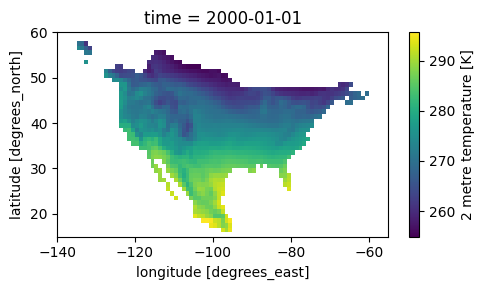

In [11]:
ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
ds_na["t2m"].isel(time=0).plot()
plt.tight_layout()

To prepare the data for training, we convert it to a Pandas `DataFrame`.
The data also has to be split into training and testing groups. The `create_train_test_dataframes` will do this.

With `create_train_test_dataframes(random_seed=0)`, the split can be made repeatably (as long as the input data size does not change).

In [12]:
from src import traintest
df_train, df_test = traintest.create_train_test_dataframes(ds_na, test_size=0.10)

In [13]:
df_train.head(3)

,time,latitude,longitude,bio_flux_opt,transcom_regions,d2m,mslhf,msshf,sp,ssr,str,t2m,tp,biomass
0,2000-01-01,16.5,-97.5,-2.860331e-07,2.0,284.489929,-33.902569,-81.739761,89772.640625,18036394.0,-7892254.5,292.982025,0.000047,45.289826
1,2000-01-01,16.5,-96.5,-2.720685e-07,2.0,281.864716,-34.124084,-82.015770,85056.750000,17493444.0,-7537529.0,289.791901,0.000118,42.524410
2,2000-01-01,16.5,-95.5,7.506276e-08,2.0,287.652924,-68.941933,-69.401062,94755.796875,16611942.0,-6298474.5,294.156891,0.000348,40.658878


Now we can our ML models on the data. Here we use pycaret to try a set of models and see which type performs best.

In [14]:
X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m"]
y_key = "bio_flux_opt"

df_pycaret = df_train[X_keys + [y_key]]
df_reduced = df_pycaret[::10]

df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.

import pycaret.regression
pycs = pycaret.regression.setup(df_reduced, target=y_key)# normalize=True, normalize_method="robust")
best = pycs.compare_models(round=2)

/tmp/ipykernel_132735/2172964924.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.


,Description,Value
0,Session id,3959
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(26561, 7)"
4,Transformed data shape,"(26561, 7)"
5,Transformed train set shape,"(18592, 7)"
6,Transformed test set shape,"(7969, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.39,0.36,0.60,0.63,0.27,4.71,1.82
et,Extra Trees Regressor,0.39,0.37,0.60,0.63,0.27,5.00,0.66
lightgbm,Light Gradient Boosting Machine,0.39,0.36,0.60,0.63,0.27,5.25,0.12
gbr,Gradient Boosting Regressor,0.41,0.40,0.63,0.60,0.28,5.81,0.87
lar,Least Angle Regression,0.51,0.54,0.74,0.45,0.32,8.03,0.01
ridge,Ridge Regression,0.51,0.54,0.74,0.45,0.32,8.02,0.01
br,Bayesian Ridge,0.51,0.54,0.74,0.45,0.32,8.06,0.01
lr,Linear Regression,0.51,0.54,0.74,0.45,0.32,8.05,0.24
en,Elastic Net,0.51,0.56,0.74,0.44,0.33,7.70,0.02
lasso,Lasso Regression,0.51,0.56,0.75,0.43,0.33,7.67,0.02


By including biomass info, we get a slightly better model performance:

In [15]:
X_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "biomass"]
y_key = "bio_flux_opt"

df_pycaret = df_train[X_keys + [y_key]]
df_reduced = df_pycaret[::10]

df_reduced["bio_flux_opt"] = df_reduced["bio_flux_opt"]*1e6  # So RMSE etc. are easier to interpret.

import pycaret.regression
pycs = pycaret.regression.setup(df_reduced, target=y_key)# normalize=True, normalize_method="robust")
best = pycs.compare_models(round=2)

,Description,Value
0,Session id,3163
1,Target,bio_flux_opt
2,Target type,Regression
3,Original data shape,"(26561, 8)"
4,Transformed data shape,"(26561, 8)"
5,Transformed train set shape,"(18592, 8)"
6,Transformed test set shape,"(7969, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.38,0.36,0.60,0.65,0.26,9.00,2.14
et,Extra Trees Regressor,0.38,0.35,0.59,0.65,0.26,6.80,0.69
lightgbm,Light Gradient Boosting Machine,0.38,0.35,0.59,0.65,0.26,9.30,0.06
gbr,Gradient Boosting Regressor,0.41,0.39,0.63,0.61,0.27,15.45,1.03
lar,Least Angle Regression,0.51,0.55,0.74,0.45,0.32,27.00,0.01
ridge,Ridge Regression,0.51,0.55,0.74,0.45,0.32,27.00,0.01
br,Bayesian Ridge,0.51,0.55,0.74,0.45,0.32,26.94,0.01
lr,Linear Regression,0.51,0.55,0.74,0.45,0.32,26.79,0.02
en,Elastic Net,0.51,0.56,0.75,0.44,0.33,22.91,0.02
lasso,Lasso Regression,0.51,0.57,0.75,0.43,0.33,22.02,0.02
